In [ ]:
The Approach I am using here is:
  1. As the data is distributed in 7 files which are in .parquet format, I first created a bucket in google cloud storage and created a table concating all the files.
  2. The data table is very big in size (25.2gb) hence when I trying to  capture it in a dataframe using BigQuery, the system was having a tough time load it.Hence I used sampled data.
  3. As the dataset is very imbanced (i.e only 364 records out of 6.7 million were labelled as 1), I created a dataframe which comprised of all records labelled as 1 (i.e 364) and 1000 records labelled as 0.
  4. I have used min max scalling as there were few columns which had very big values and that would have effected the model and would have created biasness

### 1. Data Import

#### Creating a dataframe of rows with label as '1'

In [3]:
query="""
SELECT
* FROM Lucid_0305.table1 where label=1 limit 10000
"""

import google.datalab.bigquery as bq
df = bq.Query(query).execute().result().to_dataframe()
df.head()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f493,f494,f495,f496,f497,f498,f499,f500,f501,f502
0,1,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [4]:
## Importing Libraries

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.metrics import r2_score, mean_squared_error,f1_score, confusion_matrix, precision_score, recall_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
plt.style.use('seaborn') #set same style for all plots

In [6]:
df.describe()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f493,f494,f495,f496,f497,f498,f499,f500,f501,f502
count,364.0,364.000000,3.640000e+02,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,...,364.0,364.0,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,1.0,3.950549,3.225865e+06,0.074176,6.013736,0.501145,0.071592,3900.063564,0.978022,0.052198,...,0.0,0.0,0.428571,0.065934,0.255495,0.206044,0.002747,0.005495,0.032967,0.002747
std,0.0,7.630429,7.615695e+06,0.577344,8.739406,0.728284,0.104041,7886.965607,3.994426,0.234775,...,0.0,0.0,0.495553,0.248508,0.436739,0.405019,0.052414,0.074023,0.178796,0.052414
min,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000e+00,0.000000,1.000000,0.083333,0.011905,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,2.000000,7.048580e+05,0.000000,3.000000,0.250000,0.035714,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,4.250000,3.523576e+06,0.000000,7.000000,0.583333,0.083333,4810.000000,0.000000,0.000000,...,0.0,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.0,69.000000,8.388327e+07,10.000000,52.000000,4.333333,0.619048,48313.000000,39.000000,2.000000,...,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Creating a dataframe of rows with label as '0'

In [5]:
query1="""
SELECT
* FROM Lucid_0305.table1 where label=0 limit 1000
"""

import google.datalab.bigquery as bq
df1 = bq.Query(query1).execute().result().to_dataframe()
df1.head()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f493,f494,f495,f496,f497,f498,f499,f500,f501,f502
0,0,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0.0,0.0,6965.0,6,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Concating the dataframes

In [6]:
frames=[df,df1]
data=pd.concat(frames)
data.describe()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f493,f494,f495,f496,f497,f498,f499,f500,f501,f502
count,1364.000000,1364.000000,1.364000e+03,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,...,1364.0,1364.0,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000
mean,0.266862,1.318182,1.000528e+06,0.021261,2.052053,0.171004,0.024429,1657.612271,0.530059,0.018328,...,0.0,0.0,0.116569,0.019795,0.174487,0.230938,0.293255,0.005865,0.157625,0.001466
std,0.442482,5.068417,4.307993e+06,0.302088,5.871284,0.489274,0.069896,5451.689753,3.034138,0.139546,...,0.0,0.0,0.321024,0.139345,0.379667,0.421588,0.455421,0.076387,0.364522,0.038278
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000e+00,0.000000,1.000000,0.083333,0.011905,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,89.000000,8.388327e+07,10.000000,53.000000,4.416667,0.630952,48313.000000,39.000000,2.000000,...,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
data['label'].value_counts()

0    1000
1     364
Name: label, dtype: int64

### 2. Preprocessing

#### Spliting the dataset into training and testing

In [7]:
from sklearn.model_selection import train_test_split
X = data.iloc[:,1:]
Y = data.loc[:,'label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

#Splitting train and test datasets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

print('Shape of train {}, shape of test {}'.format(X_train.shape, X_test.shape))

Shape of train (954, 502), shape of test (410, 502)


#### Using Min Max Scaling to scale the dataset 

In [8]:
#Checking results of 2 scalars

from sklearn.preprocessing import MinMaxScaler

#MinMax
MinMax = MinMaxScaler(feature_range= (0,1))
X_train = MinMax.fit_transform(X_train)
X_test = MinMax.transform(X_test)

### 3. Models

#### i. Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

lreg_clf = LogisticRegression()

param_grid = {'penalty':['l1', 'l2']}

grid_search = GridSearchCV(lreg_clf , param_grid, cv = 5 , return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2']}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [10]:
grid_search.best_params_

{'penalty': 'l2'}

In [11]:
grid_search.best_score_

0.9475890985324947

In [12]:
results = pd.DataFrame(index=None, columns=['model','train_Rsquare','test_Rsquare','train_MSE','test_MSE','f1_score_train','f1_score_test','train_r2_score','test_r2_score','train_precision_score','test_precision_score'])

In [13]:
lreg_clf = LogisticRegression(penalty = 'l2')
lreg_clf.fit(X_train,y_train)
y_lreg_clf = lreg_clf.predict(X_test)
train_Rsquare = lreg_clf.score(X_train, y_train)
test_Rsquare = lreg_clf.score(X_test, y_test)
train_MSE = mean_squared_error(y_train, lreg_clf.predict(X_train))
test_MSE = mean_squared_error(y_test, lreg_clf.predict(X_test))
f1_score_train=f1_score(y_train, lreg_clf.predict(X_train))
f1_score_test=f1_score(y_test, lreg_clf.predict(X_test))
train_r2_score=r2_score(y_train,lreg_clf.predict(X_train))
test_r2_score=r2_score(y_test,lreg_clf.predict(X_test))
train_precision_score=precision_score(y_train,lreg_clf.predict(X_train))
test_precision_score=precision_score(y_test,lreg_clf.predict(X_test))
results = results.append(pd.Series({'model':'Logistic Regression','train_Rsquare':train_Rsquare, 'test_Rsquare':test_Rsquare, 'train_MSE':train_MSE,'test_MSE':test_MSE,
                                    'f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_r2_score':train_r2_score,'test_r2_score':test_r2_score,
                                    'train_precision_score':train_precision_score,'test_precision_score':test_precision_score}),ignore_index=True )
results

,model,train_Rsquare,test_Rsquare,train_MSE,test_MSE,f1_score_train,f1_score_test,train_r2_score,test_r2_score,train_precision_score,test_precision_score
0,Logistic Regression,0.958071,0.939024,0.041929,0.060976,0.915966,0.876847,0.785913,0.687586,0.986425,0.946809


In [14]:
recall_score(y_train,lreg_clf.predict(X_train))

0.8549019607843137

In [15]:
recall_score(y_test,lreg_clf.predict(X_test))

0.8165137614678899

In [16]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_train, lreg_clf.predict(X_train),pos_label=1)
metrics.auc(fpr, tpr)

0.9253050576453757

### I just wanted to see different metrics that we can consider to evaluate the model. However as it is a classification problem, the best metric would be f1_score and Precision and Recall score.

#### If the exact problem was known it would have been much easier to consider either of the 2 best metric. As f1 score takes the average of the precision and recall which can be pretty bad in some situations hence we will take the harmonic mean i.e. f_beta_score

In [17]:
f_beta_score=precision_recall_fscore_support(y_train,lreg_clf.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]

In [18]:
results = pd.DataFrame(index=None, columns=['model','f1_score_train','f1_score_test','train_precision_score','test_precision_score','f_beta_score_train','f_beta_score_test','train_recall_score','test_recall_score'])
train_recall_score=recall_score(y_train,lreg_clf.predict(X_train))
test_recall_score=recall_score(y_test,lreg_clf.predict(X_test))
f_beta_score_train=precision_recall_fscore_support(y_train,lreg_clf.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
f_beta_score_test=precision_recall_fscore_support(y_test,lreg_clf.predict(X_test), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
results = results.append(pd.Series({'model':'Logistic Regression','f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_precision_score':train_precision_score,'train_recall_score':train_recall_score,
                                    'test_recall_score':test_recall_score,'test_precision_score':test_precision_score,'f_beta_score_train':f_beta_score_train,'f_beta_score_test':f_beta_score_test})
                         ,ignore_index=True )
results

,model,f1_score_train,f1_score_test,train_precision_score,test_precision_score,f_beta_score_train,f_beta_score_test,train_recall_score,test_recall_score
0,Logistic Regression,0.915966,0.876847,0.986425,0.946809,0.957072,0.937513,0.854902,0.816514


#### ii. KNN Regressor

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
param_grid = {'n_neighbors':[3,4, 5,6, 7,8]}
grid_search = GridSearchCV(knn_clf , param_grid, cv = 5 , return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [20]:
grid_search.best_params_

{'n_neighbors': 3}

In [21]:
grid_search.best_score_

0.8962264150943396

In [22]:
from sklearn.metrics import r2_score, mean_squared_error
knn_clf = KNeighborsClassifier(n_neighbors = 3)
knn_clf.fit(X_train,y_train)
y_knn_clf = knn_clf.predict(X_test)
train_precision_score=precision_score(y_train,knn_clf.predict(X_train))
test_precision_score=precision_score(y_test,knn_clf.predict(X_test))
f1_score_train=f1_score(y_train, knn_clf.predict(X_train))
f1_score_test=f1_score(y_test, knn_clf.predict(X_test))
train_recall_score=recall_score(y_train,knn_clf.predict(X_train))
test_recall_score=recall_score(y_test,knn_clf.predict(X_test))
f_beta_score_train=precision_recall_fscore_support(y_train,knn_clf.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
f_beta_score_test=precision_recall_fscore_support(y_test,knn_clf.predict(X_test), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
results = results.append(pd.Series({'model':'KNN Classifier','f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_precision_score':train_precision_score,'train_recall_score':train_recall_score,
                                    'test_recall_score':test_recall_score,'test_precision_score':test_precision_score,'f_beta_score_train':f_beta_score_train,'f_beta_score_test':f_beta_score_test})
                         ,ignore_index=True )
results

,model,f1_score_train,f1_score_test,train_precision_score,test_precision_score,f_beta_score_train,f_beta_score_test,train_recall_score,test_recall_score
0,Logistic Regression,0.915966,0.876847,0.986425,0.946809,0.957072,0.937513,0.854902,0.816514
1,KNN Classifier,0.877944,0.755556,0.966981,0.957746,0.938392,0.884541,0.803922,0.623853


#### iii. Support Vector Classification

In [23]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [24]:
from sklearn.svm import SVC

param_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000], 'max_iter':[1000,10000] }

grid_search = GridSearchCV(SVC(random_state=0,kernel='linear'), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000], 'max_iter': [1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
grid_search.best_params_

{'C': 0.5, 'max_iter': 1000}

In [26]:
grid_search.best_score_

0.940251572327044

In [27]:
lsvc_clf = SVC(C=0.5, max_iter=1000,kernel='linear',random_state=0)
lsvc_clf.fit(X_train,y_train)
y_lsvc_clf = lsvc_clf.predict(X_test)
train_precision_score=precision_score(y_train,lsvc_clf.predict(X_train))
test_precision_score=precision_score(y_test,lsvc_clf.predict(X_test))
f1_score_train=f1_score(y_train, lsvc_clf.predict(X_train))
f1_score_test=f1_score(y_test, lsvc_clf.predict(X_test))
train_recall_score=recall_score(y_train,lsvc_clf.predict(X_train))
test_recall_score=recall_score(y_test,lsvc_clf.predict(X_test))
f_beta_score_train=precision_recall_fscore_support(y_train,lsvc_clf.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
f_beta_score_test=precision_recall_fscore_support(y_test,lsvc_clf.predict(X_test), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
results = results.append(pd.Series({'model':'SCV-Linear','f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_precision_score':train_precision_score,'train_recall_score':train_recall_score,
                                    'test_recall_score':test_recall_score,'test_precision_score':test_precision_score,'f_beta_score_train':f_beta_score_train,'f_beta_score_test':f_beta_score_test})
                         ,ignore_index=True )
results

,model,f1_score_train,f1_score_test,train_precision_score,test_precision_score,f_beta_score_train,f_beta_score_test,train_recall_score,test_recall_score
0,Logistic Regression,0.915966,0.876847,0.986425,0.946809,0.957072,0.937513,0.854902,0.816514
1,KNN Classifier,0.877944,0.755556,0.966981,0.957746,0.938392,0.884541,0.803922,0.623853
2,SCV-Linear,0.905660,0.891089,0.972973,0.967742,0.951742,0.944911,0.847059,0.825688


#### iv. Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=10)
param_grid = {'max_depth': [5,6,7, 8,10,12,15, 20, 50, 100]}

grid_search = GridSearchCV(dt_clf, param_grid, cv = 5, return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 6, 7, 8, 10, 12, 15, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [29]:
grid_search.best_params_

{'max_depth': 8}

In [30]:
grid_search.best_score_

0.9580712788259959

In [31]:
dt_clf = DecisionTreeClassifier(max_depth = 8)
dt_clf.fit(X_train,y_train)
y_dt_clf = dt_clf.predict(X_test)
train_precision_score=precision_score(y_train,dt_clf.predict(X_train))
test_precision_score=precision_score(y_test,dt_clf.predict(X_test))
f1_score_train=f1_score(y_train, dt_clf.predict(X_train))
f1_score_test=f1_score(y_test, dt_clf.predict(X_test))
train_recall_score=recall_score(y_train,dt_clf.predict(X_train))
test_recall_score=recall_score(y_test,dt_clf.predict(X_test))
f_beta_score_train=precision_recall_fscore_support(y_train,dt_clf.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
f_beta_score_test=precision_recall_fscore_support(y_test,dt_clf.predict(X_test), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
results = results.append(pd.Series({'model':'Decision Tree','f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_precision_score':train_precision_score,'train_recall_score':train_recall_score,
                                    'test_recall_score':test_recall_score,'test_precision_score':test_precision_score,'f_beta_score_train':f_beta_score_train,'f_beta_score_test':f_beta_score_test})
                         ,ignore_index=True )
results

,model,f1_score_train,f1_score_test,train_precision_score,test_precision_score,f_beta_score_train,f_beta_score_test,train_recall_score,test_recall_score
0,Logistic Regression,0.915966,0.876847,0.986425,0.946809,0.957072,0.937513,0.854902,0.816514
1,KNN Classifier,0.877944,0.755556,0.966981,0.957746,0.938392,0.884541,0.803922,0.623853
2,SCV-Linear,0.905660,0.891089,0.972973,0.967742,0.951742,0.944911,0.847059,0.825688
3,Decision Tree,0.980080,0.898551,0.995951,0.948980,0.989464,0.947879,0.964706,0.853211


#### v. Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

#Tuning ridge on new dataset
param_grid = {"max_depth": [3, 5, 6,8],
              "max_features": sp_randint(1, 40),
              "min_samples_split": sp_randint(2, 30),
              "min_samples_leaf": sp_randint(1, 20),
              "bootstrap": [True, False]}
random_search = RandomizedSearchCV(RandomForestClassifier(n_estimators=1000), param_distributions=param_grid,
                                   n_iter=20, random_state=0,n_jobs=-1, return_train_score=True)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f365bfc17d0>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36573aaa90>, 'bootstrap': [True, False], 'max_depth': [3, 5, 6, 8], 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36573aac10>},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_sc

In [33]:
random_search.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': 32,
 'min_samples_leaf': 2,
 'min_samples_split': 3}

In [34]:
random_search.best_score_

0.929769392033543

In [35]:
rf_clf = RandomForestClassifier(bootstrap=True,max_depth=6,max_features=32,min_samples_leaf=2,min_samples_split=3)
rf_clf.fit(X_train,y_train)
y_rf_clf = rf_clf.predict(X_test)
train_precision_score=precision_score(y_train,rf_clf.predict(X_train))
test_precision_score=precision_score(y_test,rf_clf.predict(X_test))
f1_score_train=f1_score(y_train, rf_clf.predict(X_train))
f1_score_test=f1_score(y_test, rf_clf.predict(X_test))
train_recall_score=recall_score(y_train,rf_clf.predict(X_train))
test_recall_score=recall_score(y_test,rf_clf.predict(X_test))
f_beta_score_train=precision_recall_fscore_support(y_train,rf_clf.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
f_beta_score_test=precision_recall_fscore_support(y_test,rf_clf.predict(X_test), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
results = results.append(pd.Series({'model':'Random Forest','f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_precision_score':train_precision_score,'train_recall_score':train_recall_score,
                                    'test_recall_score':test_recall_score,'test_precision_score':test_precision_score,'f_beta_score_train':f_beta_score_train,'f_beta_score_test':f_beta_score_test})
                         ,ignore_index=True )
results

,model,f1_score_train,f1_score_test,train_precision_score,test_precision_score,f_beta_score_train,f_beta_score_test,train_recall_score,test_recall_score
0,Logistic Regression,0.915966,0.876847,0.986425,0.946809,0.957072,0.937513,0.854902,0.816514
1,KNN Classifier,0.877944,0.755556,0.966981,0.957746,0.938392,0.884541,0.803922,0.623853
2,SCV-Linear,0.905660,0.891089,0.972973,0.967742,0.951742,0.944911,0.847059,0.825688
3,Decision Tree,0.980080,0.898551,0.995951,0.948980,0.989464,0.947879,0.964706,0.853211
4,Random Forest,0.898785,0.829493,0.928870,0.833333,0.947037,0.909623,0.870588,0.825688


#### vi. SVC-Kernalized

In [36]:
param_grid = {'C':[0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000], 'max_iter':[1000,10000], 'gamma':[0.001, 0.01, 0.1, 0.5, 1, 10]}

grid_search = GridSearchCV(SVC(random_state=0,kernel='rbf'), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000], 'max_iter': [1000, 10000], 'gamma': [0.001, 0.01, 0.1, 0.5, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [37]:
grid_search.best_params_

{'C': 10, 'gamma': 0.1, 'max_iter': 1000}

In [38]:
grid_search.best_score_

0.9412997903563941

In [39]:
rbfsvc_clf = SVC(C=10,gamma=0.1, max_iter=1000,kernel='rbf',random_state=0,probability=True)
rbfsvc_clf.fit(X_train,y_train)
y_rbfsvc_clf = rbfsvc_clf.predict(X_test)
train_precision_score=precision_score(y_train,rbfsvc_clf.predict(X_train))
test_precision_score=precision_score(y_test,rbfsvc_clf.predict(X_test))
f1_score_train=f1_score(y_train, rbfsvc_clf.predict(X_train))
f1_score_test=f1_score(y_test, rbfsvc_clf.predict(X_test))
train_recall_score=recall_score(y_train,rbfsvc_clf.predict(X_train))
test_recall_score=recall_score(y_test,rbfsvc_clf.predict(X_test))
f_beta_score_train=precision_recall_fscore_support(y_train,rbfsvc_clf.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
f_beta_score_test=precision_recall_fscore_support(y_test,rbfsvc_clf.predict(X_test), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
results = results.append(pd.Series({'model':'SCV-Kernalized','f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_precision_score':train_precision_score,'train_recall_score':train_recall_score,
                                    'test_recall_score':test_recall_score,'test_precision_score':test_precision_score,'f_beta_score_train':f_beta_score_train,'f_beta_score_test':f_beta_score_test})
                         ,ignore_index=True )
results

,model,f1_score_train,f1_score_test,train_precision_score,test_precision_score,f_beta_score_train,f_beta_score_test,train_recall_score,test_recall_score
0,Logistic Regression,0.915966,0.876847,0.986425,0.946809,0.957072,0.937513,0.854902,0.816514
1,KNN Classifier,0.877944,0.755556,0.966981,0.957746,0.938392,0.884541,0.803922,0.623853
2,SCV-Linear,0.905660,0.891089,0.972973,0.967742,0.951742,0.944911,0.847059,0.825688
3,Decision Tree,0.980080,0.898551,0.995951,0.948980,0.989464,0.947879,0.964706,0.853211
4,Random Forest,0.898785,0.829493,0.928870,0.833333,0.947037,0.909623,0.870588,0.825688
5,SCV-Kernalized,0.965517,0.904762,1.000000,0.940594,0.981980,0.950610,0.933333,0.871560


Text(0.5,1,u'Train and Test f1_score')

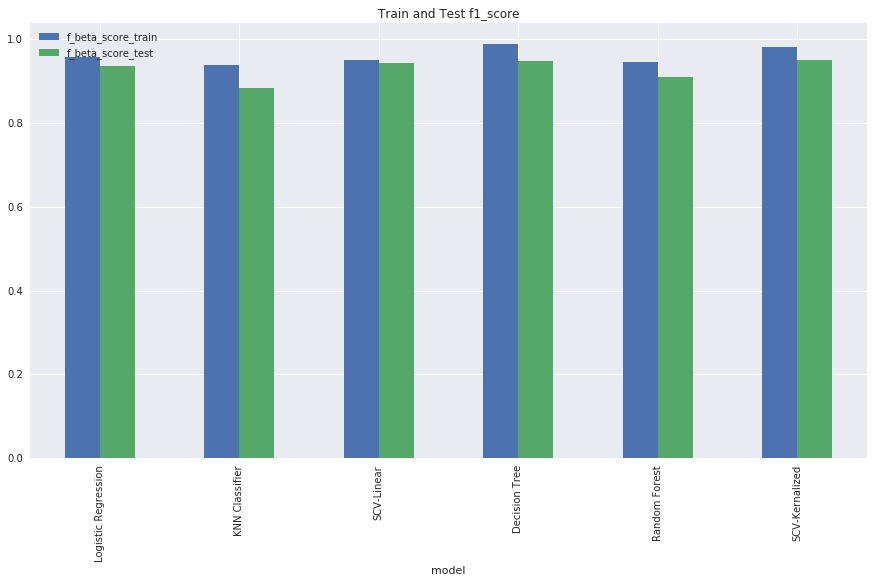

In [40]:
cols = ['model','f_beta_score_train','f_beta_score_test']
results[cols].set_index('model').plot(kind = 'bar', figsize=(15,8));
plt.title('Train and Test f1_score')

### Looks like Decision Tree and SCV kernalized models have performed the best among all. 

In [41]:
from sklearn.ensemble import VotingClassifier

hard_voting_clf = VotingClassifier(estimators=[('rbfsvc',rbfsvc_clf),('dt',dt_clf)], voting = 'hard')
hard_voting_clf.fit(X_train,y_train)
print('Train score: {0:0.2f}'.format(hard_voting_clf.score(X_train, y_train)))
print('Test score: {0:0.2f}'.format(hard_voting_clf.score(X_test, y_test)))

Train score: 0.98
Test score: 0.94


### Bagging

#### 1. Support Vector Classifier-Kernalized with Bagging

In [45]:
from sklearn.ensemble import BaggingClassifier
param_grid = {"bootstrap_features": [True,False],
             "bootstrap": [True,False]}
bagging_clf = GridSearchCV(BaggingClassifier(rbfsvc_clf), param_grid, cv = 5, return_train_score=True)
bagging_clf.fit(X_train, y_train)
train_precision_score=precision_score(y_train,rbfsvc_clf.predict(X_train))
test_precision_score=precision_score(y_test,rbfsvc_clf.predict(X_test))
f1_score_train=f1_score(y_train, bagging_clf.predict(X_train), average = 'micro')
f1_score_test=f1_score(y_test, bagging_clf.predict(X_test), average = 'micro')
train_recall_score=recall_score(y_train,bagging_clf.predict(X_train))
test_recall_score=recall_score(y_test,bagging_clf.predict(X_test))
f_beta_score_train=precision_recall_fscore_support(y_train,bagging_clf.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
f_beta_score_test=precision_recall_fscore_support(y_test,bagging_clf.predict(X_test), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
results = results.append(pd.Series({'model':'SCV-Kernalized-Bagging','f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_precision_score':train_precision_score,'train_recall_score':train_recall_score,
                                    'test_recall_score':test_recall_score,'test_precision_score':test_precision_score,'f_beta_score_train':f_beta_score_train,'f_beta_score_test':f_beta_score_test})
                         ,ignore_index=True )
results

,model,f1_score_train,f1_score_test,train_precision_score,test_precision_score,f_beta_score_train,f_beta_score_test,train_recall_score,test_recall_score
0,Logistic Regression,0.915966,0.876847,0.986425,0.946809,0.957072,0.937513,0.854902,0.816514
1,KNN Classifier,0.877944,0.755556,0.966981,0.957746,0.938392,0.884541,0.803922,0.623853
2,SCV-Linear,0.905660,0.891089,0.972973,0.967742,0.951742,0.944911,0.847059,0.825688
3,Decision Tree,0.980080,0.898551,0.995951,0.948980,0.989464,0.947879,0.964706,0.853211
4,Random Forest,0.898785,0.829493,0.928870,0.833333,0.947037,0.909623,0.870588,0.825688
5,SCV-Kernalized,0.965517,0.904762,1.000000,0.940594,0.981980,0.950610,0.933333,0.871560
6,SCV-Kernalized-Bagging,0.982180,0.948780,1.000000,0.940594,0.981980,0.948055,0.933333,0.862385


#### 2. Logistic Regression with Bagging

In [46]:
from sklearn.ensemble import BaggingClassifier
param_grid = {"bootstrap_features": [True,False],
             "bootstrap": [True,False]}
bagging_clf = GridSearchCV(BaggingClassifier(lreg_clf), param_grid, cv = 5, return_train_score=True)
bagging_clf.fit(X_train, y_train)

train_precision_score=precision_score(y_train,bagging_clf.predict(X_train))
test_precision_score=precision_score(y_test,bagging_clf.predict(X_test))
f1_score_train=f1_score(y_train, bagging_clf.predict(X_train), average = 'micro')
f1_score_test=f1_score(y_test, bagging_clf.predict(X_test), average = 'micro')
train_recall_score=recall_score(y_train,bagging_clf.predict(X_train))
test_recall_score=recall_score(y_test,bagging_clf.predict(X_test))
f_beta_score_train=precision_recall_fscore_support(y_train,bagging_clf.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
f_beta_score_test=precision_recall_fscore_support(y_test,bagging_clf.predict(X_test), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
results = results.append(pd.Series({'model':'Logistic-with-Bagging','f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_precision_score':train_precision_score,'train_recall_score':train_recall_score,
                                    'test_recall_score':test_recall_score,'test_precision_score':test_precision_score,'f_beta_score_train':f_beta_score_train,'f_beta_score_test':f_beta_score_test})
                         ,ignore_index=True )
results

,model,f1_score_train,f1_score_test,train_precision_score,test_precision_score,f_beta_score_train,f_beta_score_test,train_recall_score,test_recall_score
0,Logistic Regression,0.915966,0.876847,0.986425,0.946809,0.957072,0.937513,0.854902,0.816514
1,KNN Classifier,0.877944,0.755556,0.966981,0.957746,0.938392,0.884541,0.803922,0.623853
2,SCV-Linear,0.905660,0.891089,0.972973,0.967742,0.951742,0.944911,0.847059,0.825688
3,Decision Tree,0.980080,0.898551,0.995951,0.948980,0.989464,0.947879,0.964706,0.853211
4,Random Forest,0.898785,0.829493,0.928870,0.833333,0.947037,0.909623,0.870588,0.825688
5,SCV-Kernalized,0.965517,0.904762,1.000000,0.940594,0.981980,0.950610,0.933333,0.871560
6,SCV-Kernalized-Bagging,0.982180,0.948780,1.000000,0.940594,0.981980,0.948055,0.933333,0.862385
7,Logistic-with-Bagging,0.958071,0.939024,1.000000,0.940594,0.957072,0.937513,0.854902,0.816514


#### 3. Decision Tree with Bagging

In [47]:
param_grid = {"bootstrap_features": [True,False],
             "bootstrap": [True,False]}
bagging_clf = GridSearchCV(BaggingClassifier(dt_clf), param_grid, cv = 5, return_train_score=True)
bagging_clf.fit(X_train, y_train)


train_precision_score=precision_score(y_train,bagging_clf.predict(X_train))
test_precision_score=precision_score(y_test,bagging_clf.predict(X_test))
f1_score_train=f1_score(y_train, bagging_clf.predict(X_train), average = 'micro')
f1_score_test=f1_score(y_test, bagging_clf.predict(X_test), average = 'micro')
train_recall_score=recall_score(y_train,bagging_clf.predict(X_train))
test_recall_score=recall_score(y_test,bagging_clf.predict(X_test))
f_beta_score_train=precision_recall_fscore_support(y_train,bagging_clf.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
f_beta_score_test=precision_recall_fscore_support(y_test,bagging_clf.predict(X_test), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
results = results.append(pd.Series({'model':'Decision Tree-with-Bagging','f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_precision_score':train_precision_score,'train_recall_score':train_recall_score,
                                    'test_recall_score':test_recall_score,'test_precision_score':test_precision_score,'f_beta_score_train':f_beta_score_train,'f_beta_score_test':f_beta_score_test})
                         ,ignore_index=True )
results

,model,f1_score_train,f1_score_test,train_precision_score,test_precision_score,f_beta_score_train,f_beta_score_test,train_recall_score,test_recall_score
0,Logistic Regression,0.915966,0.876847,0.986425,0.946809,0.957072,0.937513,0.854902,0.816514
1,KNN Classifier,0.877944,0.755556,0.966981,0.957746,0.938392,0.884541,0.803922,0.623853
2,SCV-Linear,0.905660,0.891089,0.972973,0.967742,0.951742,0.944911,0.847059,0.825688
3,Decision Tree,0.980080,0.898551,0.995951,0.948980,0.989464,0.947879,0.964706,0.853211
4,Random Forest,0.898785,0.829493,0.928870,0.833333,0.947037,0.909623,0.870588,0.825688
5,SCV-Kernalized,0.965517,0.904762,1.000000,0.940594,0.981980,0.950610,0.933333,0.871560
6,SCV-Kernalized-Bagging,0.982180,0.948780,1.000000,0.940594,0.981980,0.948055,0.933333,0.862385
7,Logistic-with-Bagging,0.958071,0.939024,1.000000,0.940594,0.957072,0.937513,0.854902,0.816514
8,Decision Tree-with-Bagging,0.989518,0.960976,0.995951,0.951456,0.989464,0.960616,0.964706,0.899083


### Boosting

#### 1. AdaBoost Classifier for Support Vector Classifier-Kernalized

In [48]:
from sklearn.ensemble import AdaBoostClassifier
param_grid = {'learning_rate':[0.0001,0.001,0.01,0.1,1]}
adaboost_clf = GridSearchCV(AdaBoostClassifier(base_estimator = rbfsvc_clf,random_state = 0), param_grid, cv=5,return_train_score=True)
adaboost_clf.fit(X_train, y_train)

train_precision_score=precision_score(y_train,adaboost_clf.predict(X_train))
test_precision_score=precision_score(y_test,adaboost_clf.predict(X_test))
f1_score_train=f1_score(y_train, adaboost_clf.predict(X_train), average = 'micro')
f1_score_test=f1_score(y_test, adaboost_clf.predict(X_test), average = 'micro')
train_recall_score=recall_score(y_train,adaboost_clf.predict(X_train))
test_recall_score=recall_score(y_test,adaboost_clf.predict(X_test))
f_beta_score_train=precision_recall_fscore_support(y_train,adaboost_clf.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
f_beta_score_test=precision_recall_fscore_support(y_test,adaboost_clf.predict(X_test), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
results = results.append(pd.Series({'model':'SCV-Kernalized-Boosting','f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_precision_score':train_precision_score,'train_recall_score':train_recall_score,
                                    'test_recall_score':test_recall_score,'test_precision_score':test_precision_score,'f_beta_score_train':f_beta_score_train,'f_beta_score_test':f_beta_score_test})
                         ,ignore_index=True )
results

,model,f1_score_train,f1_score_test,train_precision_score,test_precision_score,f_beta_score_train,f_beta_score_test,train_recall_score,test_recall_score,test f1 micro,train f1 micro
0,Logistic Regression,0.915966,0.876847,0.986425,0.946809,0.957072,0.937513,0.854902,0.816514,NaN,NaN
1,KNN Classifier,0.877944,0.755556,0.966981,0.957746,0.938392,0.884541,0.803922,0.623853,NaN,NaN
2,SCV-Linear,0.905660,0.891089,0.972973,0.967742,0.951742,0.944911,0.847059,0.825688,NaN,NaN
3,Decision Tree,0.980080,0.898551,0.995951,0.948980,0.989464,0.947879,0.964706,0.853211,NaN,NaN
4,Random Forest,0.898785,0.829493,0.928870,0.833333,0.947037,0.909623,0.870588,0.825688,NaN,NaN
5,SCV-Kernalized,0.965517,0.904762,1.000000,0.940594,0.981980,0.950610,0.933333,0.871560,NaN,NaN
6,SCV-Kernalized-Bagging,0.982180,0.948780,1.000000,0.940594,0.981980,0.948055,0.933333,0.862385,NaN,NaN
7,Logistic-with-Bagging,0.958071,0.939024,1.000000,0.940594,0.957072,0.937513,0.854902,0.816514,NaN,NaN
8,Decision Tree-with-Bagging,0.989518,0.960976,0.995951,0.951456,0.989464,0.960616,0.964706,0.899083,NaN,NaN
9,Adaboost Classifier with Logistic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.953659,0.966457


In [56]:
param_grid = {'learning_rate':[0.0001,0.001,0.01,0.1,1]}
adaboost_clf = GridSearchCV(AdaBoostClassifier(base_estimator = dt_clf,random_state = 0), param_grid, cv=5,return_train_score=True)
adaboost_clf.fit(X_train, y_train)
train_precision_score=precision_score(y_train,adaboost_clf.predict(X_train))
test_precision_score=precision_score(y_test,adaboost_clf.predict(X_test))
f1_score_train=f1_score(y_train, adaboost_clf.predict(X_train), average = 'micro')
f1_score_test=f1_score(y_test, adaboost_clf.predict(X_test), average = 'micro')
train_recall_score=recall_score(y_train,adaboost_clf.predict(X_train))
test_recall_score=recall_score(y_test,adaboost_clf.predict(X_test))
f_beta_score_train=precision_recall_fscore_support(y_train,adaboost_clf.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
f_beta_score_test=precision_recall_fscore_support(y_test,adaboost_clf.predict(X_test), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
results = results.append(pd.Series({'model':'Decision Tree-AdaBoosting','f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_precision_score':train_precision_score,'train_recall_score':train_recall_score,
                                    'test_recall_score':test_recall_score,'test_precision_score':test_precision_score,'f_beta_score_train':f_beta_score_train,'f_beta_score_test':f_beta_score_test})
                         ,ignore_index=True )
results

,model,f1_score_train,f1_score_test,train_precision_score,test_precision_score,f_beta_score_train,f_beta_score_test,train_recall_score,test_recall_score
0,Logistic Regression,0.915966,0.876847,0.986425,0.946809,0.957072,0.937513,0.854902,0.816514
1,KNN Classifier,0.877944,0.755556,0.966981,0.957746,0.938392,0.884541,0.803922,0.623853
2,SCV-Linear,0.905660,0.891089,0.972973,0.967742,0.951742,0.944911,0.847059,0.825688
3,Decision Tree,0.980080,0.898551,0.995951,0.948980,0.989464,0.947879,0.964706,0.853211
4,Random Forest,0.898785,0.829493,0.928870,0.833333,0.947037,0.909623,0.870588,0.825688
5,SCV-Kernalized,0.965517,0.904762,1.000000,0.940594,0.981980,0.950610,0.933333,0.871560
6,SCV-Kernalized-Bagging,0.982180,0.948780,1.000000,0.940594,0.981980,0.948055,0.933333,0.862385
7,Logistic-with-Bagging,0.958071,0.939024,1.000000,0.940594,0.957072,0.937513,0.854902,0.816514
8,Decision Tree-with-Bagging,0.989518,0.960976,0.995951,0.951456,0.989464,0.960616,0.964706,0.899083
9,SCV-Kernalized-Boosting,0.966457,0.953659,0.974468,0.950000,0.966009,0.953002,0.898039,0.871560


In [57]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=10, n_estimators= 500)

param_grid = {'max_features':['auto', 'log2'], 'learning_rate' : [0.01,0.1], 'max_depth':[5,10,15,30,50]}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print('Best parameters for {} {}'.format('GradientBoost', grid_search.best_params_))

train_precision_score=precision_score(y_train,grid_search.predict(X_train))
test_precision_score=precision_score(y_test,grid_search.predict(X_test))
f1_score_train=f1_score(y_train, grid_search.predict(X_train), average = 'micro')
f1_score_test=f1_score(y_test, grid_search.predict(X_test), average = 'micro')
train_recall_score=recall_score(y_train,grid_search.predict(X_train))
test_recall_score=recall_score(y_test,grid_search.predict(X_test))
f_beta_score_train=precision_recall_fscore_support(y_train,grid_search.predict(X_train), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
f_beta_score_test=precision_recall_fscore_support(y_test,grid_search.predict(X_test), beta=1.0, labels=[0,1], pos_label=1, average='weighted', warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[2]
results = results.append(pd.Series({'model':'Gradient Boosting Classifier','f1_score_train':f1_score_train,'f1_score_test':f1_score_test,'train_precision_score':train_precision_score,'train_recall_score':train_recall_score,
                                    'test_recall_score':test_recall_score,'test_precision_score':test_precision_score,'f_beta_score_train':f_beta_score_train,'f_beta_score_test':f_beta_score_test})
                         ,ignore_index=True )
results

Best parameters for GradientBoost {'max_features': 'auto', 'learning_rate': 0.1, 'max_depth': 5}


,model,f1_score_train,f1_score_test,train_precision_score,test_precision_score,f_beta_score_train,f_beta_score_test,train_recall_score,test_recall_score
0,Logistic Regression,0.915966,0.876847,0.986425,0.946809,0.957072,0.937513,0.854902,0.816514
1,KNN Classifier,0.877944,0.755556,0.966981,0.957746,0.938392,0.884541,0.803922,0.623853
2,SCV-Linear,0.905660,0.891089,0.972973,0.967742,0.951742,0.944911,0.847059,0.825688
3,Decision Tree,0.980080,0.898551,0.995951,0.948980,0.989464,0.947879,0.964706,0.853211
4,Random Forest,0.898785,0.829493,0.928870,0.833333,0.947037,0.909623,0.870588,0.825688
5,SCV-Kernalized,0.965517,0.904762,1.000000,0.940594,0.981980,0.950610,0.933333,0.871560
6,SCV-Kernalized-Bagging,0.982180,0.948780,1.000000,0.940594,0.981980,0.948055,0.933333,0.862385
7,Logistic-with-Bagging,0.958071,0.939024,1.000000,0.940594,0.957072,0.937513,0.854902,0.816514
8,Decision Tree-with-Bagging,0.989518,0.960976,0.995951,0.951456,0.989464,0.960616,0.964706,0.899083
9,SCV-Kernalized-Boosting,0.966457,0.953659,0.974468,0.950000,0.966009,0.953002,0.898039,0.871560


Text(0.5,1,u'Train and Test f1_score')

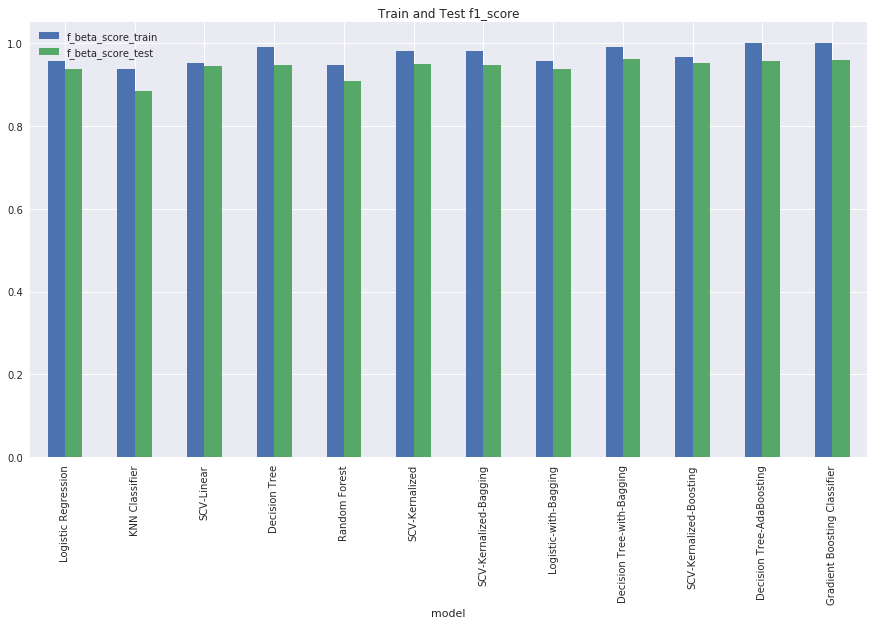

In [58]:
cols = ['model','f_beta_score_train','f_beta_score_test']
results[cols].set_index('model').plot(kind = 'bar', figsize=(15,8));
plt.title('Train and Test f1_score')

## Lets work on bigger dataset and predict using the models we have created

In [59]:
query1="""
SELECT
* FROM Lucid_0305.table1 where label=0 limit 500000
"""

import google.datalab.bigquery as bq
df2 = bq.Query(query1).execute().result().to_dataframe()
df2.head()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f493,f494,f495,f496,f497,f498,f499,f500,f501,f502
0,0,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
query1="""
SELECT * FROM Lucid_0305.table1 WHERE label IN 
    (SELECT label FROM (SELECT label FROM Lucid_0305.table1 ORDER BY RAND() LIMIT 100000) t);
"""

import google.datalab.bigquery as bq
df3 = bq.Query(query1).execute().result().to_dataframe()
df3.head()